## Bài thực hành 2

### Ngô Hồng Thông
### 22649011

## Bài 1

In [1]:
import os, random, math, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models, utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

SEED = 2025
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


#### A-Load & trực quan hoá dữ liệu (MNIST)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:13<00:00, 736kB/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 91.3kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 771kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.78MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



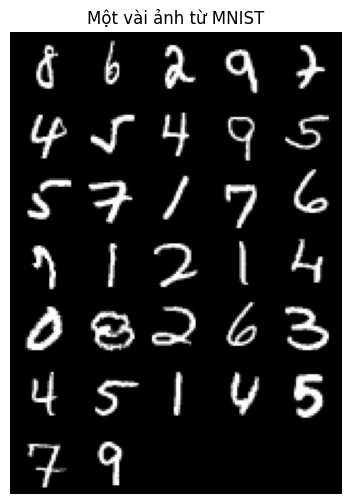

In [2]:
# Biến đổi cơ bản cho baseline
basic_tfms = transforms.Compose([
    transforms.ToTensor(),                           # [0,1]
    transforms.Normalize((0.1307,), (0.3081,)),     # chuẩn hoá theo thống kê MNIST
])

root = "./data"

full_train = datasets.MNIST(root, train=True, download=True, transform=basic_tfms)
test_set   = datasets.MNIST(root, train=False, download=True, transform=basic_tfms)

# Chia train/val
val_ratio = 0.1
val_len = int(len(full_train) * val_ratio)
train_len = len(full_train) - val_len
train_set, val_set = random_split(full_train, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Trực quan hoá
def show_batch(dl, n=32):
    x, y = next(iter(dl))
    grid = utils.make_grid(x[:n], nrow=int(math.sqrt(n)), padding=2, normalize=True)
    plt.figure(figsize=(6,6)); plt.axis("off"); plt.title("Một vài ảnh từ MNIST"); plt.imshow(np.transpose(grid, (1,2,0))); plt.show()

show_batch(train_loader)


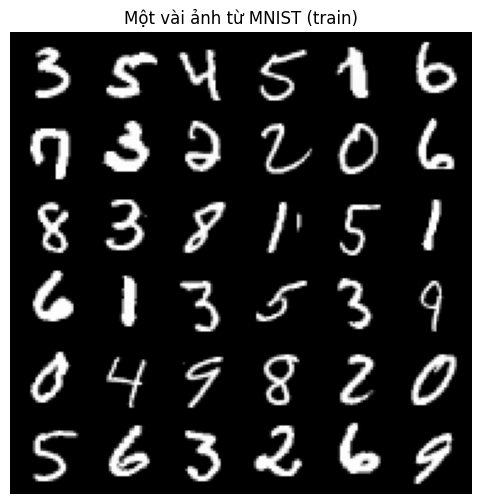

Nhãn 36 mẫu đầu: [3, 5, 4, 5, 1, 6, 7, 3, 2, 2, 0, 6, 8, 3, 8, 1, 5, 1, 6, 1, 3, 5, 3, 9, 0, 4, 9, 8, 2, 0, 5, 6, 3, 2, 6, 9]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

x, y = next(iter(train_loader))             # x: (B,1,28,28), y: (B,)
grid = make_grid(x[:36], nrow=6, normalize=True, padding=2)
plt.figure(figsize=(6,6)); plt.axis('off')
plt.title('Một vài ảnh từ MNIST (train)')
plt.imshow(np.transpose(grid, (1,2,0))); plt.show()

print("Nhãn 36 mẫu đầu:", y[:36].tolist())


In [4]:
from collections import Counter
counts = Counter([label for _, label in full_train])   # trên 60k gốc
print("Phân phối nhãn train gốc:", counts)

Phân phối nhãn train gốc: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [5]:
xb, yb = next(iter(train_loader))
print("Batch images:", xb.shape, "dtype:", xb.dtype)   # kỳ vọng: (B,1,28,28), float32
print("Batch labels:", yb.shape, "dtype:", yb.dtype)   # kỳ vọng: (B,),      int64
print("Min/Max sau Normalize:", float(xb.min()), float(xb.max()))

Batch images: torch.Size([128, 1, 28, 28]) dtype: torch.float32
Batch labels: torch.Size([128]) dtype: torch.int64
Min/Max sau Normalize: -0.4242129623889923 2.821486711502075


### B - Xây dựng mô hình CNN: gồm lớp tích chập, pooling, fully-connected; dùng ReLU, Softmax.

In [ ]:
# Mô hình bằng thư viện

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Block 1: 1x28x28 -> 32x14x14
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # giữ H,W
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 28->14
            nn.Dropout(0.25),
        )
        # Block 2: 32x14x14 -> 64x7x7
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 14->7
            nn.Dropout(0.25),
        )
        # Classifier: 64*7*7 -> 128 -> 10
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.head = nn.Linear(128, num_classes)  # logits

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        logits = self.head(x)   # không softmax ở đây (dùng CrossEntropyLoss)
        return logits

# Ví dụ suy luận lấy xác suất:
# probs = torch.softmax(model(images), dim=1)


In [ ]:
# Mô hình bằng tay

import torch
import torch.nn as nn
import torch.nn.functional as F

# ======== các "layer" build tay ========

def relu(x):
    # dùng toán tử cơ bản để giữ autograd
    return x.clamp_min(0.0)

def dropout(x, p=0.5, training=True):
    if (not training) or p == 0.0:
        return x
    # mask ~ Bernoulli(1-p); scale để giữ kỳ vọng
    mask = torch.empty_like(x).bernoulli_(1 - p) / (1 - p)
    return x * mask

def conv2d(x, weight, bias=None, stride=1, padding=0):
    """
    x: (N, Cin, H, W)
    weight: (Cout, Cin, k, k)
    bias: (Cout,)
    return: (N, Cout, H_out, W_out)
    """
    N, Cin, H, W   = x.shape
    Cout, _, k, _  = weight.shape

    if padding > 0:
        x = F.pad(x, (padding, padding, padding, padding))

    # (N, Cin*k*k, L)
    patches = F.unfold(x, kernel_size=k, stride=stride)

    # Tính tích chập theo batch: (N, L, Cout)
    CinK = Cin * k * k
    Wmat = weight.view(Cout, CinK)                 # (Cout, CinK)
    out  = torch.matmul(patches.transpose(1, 2),   # (N, L, CinK)
                        Wmat.t())                  # (CinK, Cout) -> (N, L, Cout)

    # Đưa về (N, Cout, L)
    out = out.permute(0, 2, 1)

    if bias is not None:
        out = out + bias.view(1, -1, 1)            # broadcast an toàn

    # Gấp lại (N, Cout, H_out, W_out)
    H_out = (H + 2*padding - k) // stride + 1
    W_out = (W + 2*padding - k) // stride + 1
    out = out.view(N, Cout, H_out, W_out)
    return out


def maxpool2d_2x2(x):
    """
    MaxPool với kernel=2, stride=2. Cài bằng unfold + max.
    x: (N, C, H, W)
    """
    N, C, H, W = x.shape
    # nếu H,W lẻ thì cắt bớt 1 hàng/cột
    H2 = H - (H % 2); W2 = W - (W % 2)
    x = x[:, :, :H2, :W2]
    # unfold theo từng kênh
    patches = F.unfold(x, kernel_size=2, stride=2)       # (N, C*4, L)
    patches = patches.view(N, C, 4, -1)                  # 4 phần tử/patch
    out, _ = patches.max(dim=2)                          # (N, C, L)
    # reshape về ảnh
    H_out, W_out = H2 // 2, W2 // 2
    out = out.view(N, C, H_out, W_out)
    return out

class LinearManual(nn.Module):
    def __init__(self, fin, fout):
        super().__init__()
        # He init gần giống mặc định cho ReLU
        self.W = nn.Parameter(torch.randn(fout, fin) * (2.0/fin)**0.5)
        self.b = nn.Parameter(torch.zeros(fout))

    def forward(self, x):
        # x: (N, fin)
        return x @ self.W.t() + self.b

# ======== CNN build tay theo kiến trúc cũ ========

class SimpleCNNManual(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Conv block 1: 1x28x28 -> 32x14x14
        self.W1a = nn.Parameter(torch.randn(32, 1, 3, 3)  * (2.0/(1*3*3))**0.5)
        self.b1a = nn.Parameter(torch.zeros(32))
        self.W1b = nn.Parameter(torch.randn(32, 32, 3, 3) * (2.0/(32*3*3))**0.5)
        self.b1b = nn.Parameter(torch.zeros(32))

        # Conv block 2: 32x14x14 -> 64x7x7
        self.W2a = nn.Parameter(torch.randn(64, 32, 3, 3) * (2.0/(32*3*3))**0.5)
        self.b2a = nn.Parameter(torch.zeros(64))
        self.W2b = nn.Parameter(torch.randn(64, 64, 3, 3) * (2.0/(64*3*3))**0.5)
        self.b2b = nn.Parameter(torch.zeros(64))

        # Classifier
        self.fc1 = LinearManual(64*7*7, 128)
        self.fc2 = LinearManual(128, num_classes)

        # dropout probs
        self.p_drop1 = 0.25
        self.p_drop2 = 0.25
        self.p_drop3 = 0.50

    def forward(self, x):
        # Block 1
        x = conv2d(x, self.W1a, self.b1a, stride=1, padding=1)
        x = relu(x)
        x = conv2d(x, self.W1b, self.b1b, stride=1, padding=1)
        x = relu(x)
        x = maxpool2d_2x2(x)                       # 28->14
        x = dropout(x, p=self.p_drop1, training=self.training)

        # Block 2
        x = conv2d(x, self.W2a, self.b2a, stride=1, padding=1)
        x = relu(x)
        x = conv2d(x, self.W2b, self.b2b, stride=1, padding=1)
        x = relu(x)
        x = maxpool2d_2x2(x)                       # 14->7
        x = dropout(x, p=self.p_drop2, training=self.training)

        # Classifier
        x = x.flatten(1)                           # (N, 64*7*7)
        x = self.fc1(x)
        x = relu(x)
        x = dropout(x, p=self.p_drop3, training=self.training)
        logits = self.fc2(x)                       # KHÔNG softmax khi train
        return logits


### C – Huấn luyện & đánh giá thật gọn mà đủ sâu: train mô hình, đánh giá trên validation và test, so sánh Accuracy, Loss và vẽ Confusion Matrix.

c:\Users\thong\workplace\IUH\4RD_YEAR_COLLEGE\semester_1\deep learnning\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | train 0.2812/0.9109 | val 0.0708/0.9780 | lr 1.00e-03
Epoch 02 | train 0.0917/0.9726 | val 0.0429/0.9870 | lr 1.00e-03
Epoch 03 | train 0.0692/0.9802 | val 0.0437/0.9872 | lr 1.00e-03
Epoch 04 | train 0.0593/0.9834 | val 0.0369/0.9883 | lr 1.00e-03
Epoch 05 | train 0.0515/0.9845 | val 0.0271/0.9913 | lr 1.00e-03
Epoch 06 | train 0.0444/0.9868 | val 0.0270/0.9912 | lr 1.00e-03
Epoch 07 | train 0.0411/0.9876 | val 0.0273/0.9913 | lr 1.00e-03
Epoch 08 | train 0.0379/0.9881 | val 0.0289/0.9918 | lr 1.00e-03
Epoch 09 | train 0.0335/0.9901 | val 0.0290/0.9918 | lr 5.00e-04
Epoch 10 | train 0.0238/0.9930 | val 0.0216/0.9932 | lr 5.00e-04
Epoch 11 | train 0.0214/0.9933 | val 0.0209/0.9940 | lr 5.00e-04
Epoch 12 | train 0.0208/0.9935 | val 0.0185/0.9952 | lr 5.00e-04
Epoch 13 | train 0.0204/0.9940 | val 0.0201/0.9940 | lr 5.00e-04
Epoch 14 | train 0.0195/0.9935 | val 0.0228/0.9937 | lr 5.00e-04
Epoch 15 | train 0.0187/0.9942 | val 0.0231/0.9940 | lr 2.50e-04
Epoch 16 | train 0.0140/0

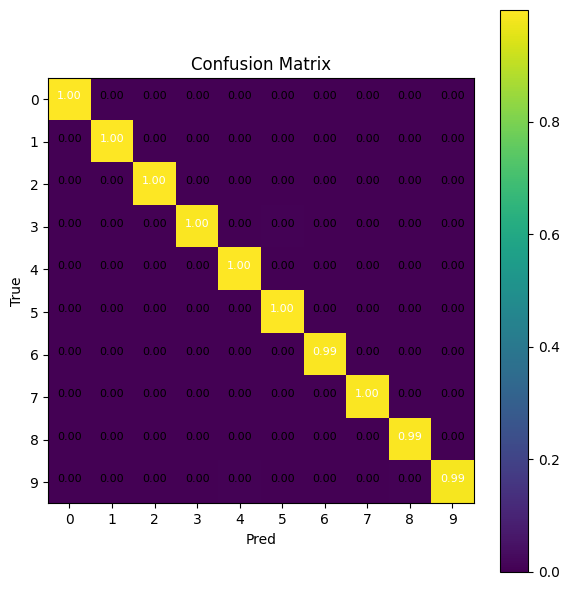

              precision    recall  f1-score   support

           0     0.9969    0.9980    0.9975       980
           1     0.9956    0.9991    0.9974      1135
           2     0.9961    0.9971    0.9966      1032
           3     0.9960    0.9950    0.9955      1010
           4     0.9939    0.9980    0.9959       982
           5     0.9900    0.9955    0.9927       892
           6     0.9990    0.9937    0.9963       958
           7     0.9961    0.9951    0.9956      1028
           8     0.9918    0.9949    0.9933       974
           9     0.9980    0.9871    0.9925      1009

    accuracy                         0.9954     10000
   macro avg     0.9953    0.9954    0.9953     10000
weighted avg     0.9954    0.9954    0.9954     10000



In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt, itertools
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

# 1) Khởi tạo model từ lớp đã định nghĩa ở câu B
model = SimpleCNN(num_classes=10).to(device)

# 2) Loss/Optimizer/Scheduler + EarlyStopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience, self.min_delta = patience, min_delta
        self.best = None; self.count = 0; self.stop = False
    def __call__(self, val_loss):
        if self.best is None or val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0
        else:
            self.count += 1
            if self.count >= self.patience: self.stop = True

def train_one_epoch(model, loader):
    model.train(); total=correct=0; run_loss=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits,y)
        loss.backward(); optimizer.step()
        run_loss += loss.item()*x.size(0)
        correct  += (logits.argmax(1)==y).sum().item()
        total    += x.size(0)
    return run_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); total=correct=0; run_loss=0.0
    preds_all, targets_all = [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits,y)
        run_loss += loss.item()*x.size(0)
        correct  += (logits.argmax(1)==y).sum().item()
        total    += x.size(0)
        preds_all.append(logits.argmax(1).cpu())
        targets_all.append(y.cpu())
    preds_all   = torch.cat(preds_all).numpy()
    targets_all = torch.cat(targets_all).numpy()
    return run_loss/total, correct/total, preds_all, targets_all

def plot_confmat(y_true, y_pred, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    if normalize: cm = cm.astype(float)/cm.sum(axis=1, keepdims=True)
    import numpy as np
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix'); plt.colorbar()
    ticks = np.arange(10); labs=[str(i) for i in range(10)]
    plt.xticks(ticks,labs); plt.yticks(ticks,labs)
    fmt = '.2f' if normalize else 'd'; th = cm.max()/2
    for i in range(10):
        for j in range(10):
            plt.text(j,i,format(cm[i,j],fmt),ha='center',
                     color='white' if cm[i,j]>th else 'black', fontsize=8)
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

# 3) Train + validate
EPOCHS = 30
stopper = EarlyStopping(patience=5)
history = []
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc, _, _ = evaluate(model, val_loader)
    scheduler.step(va_loss); stopper(va_loss)
    history.append((ep, tr_loss, tr_acc, va_loss, va_acc, optimizer.param_groups[0]['lr']))
    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} "
          f"| val {va_loss:.4f}/{va_acc:.4f} | lr {optimizer.param_groups[0]['lr']:.2e}")
    if stopper.stop:
        print("Early stopping triggered."); break

# 4) Đánh giá cuối trên test (KHÔNG dùng để chọn tham số)
test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader)
print(f"\nTEST | loss {test_loss:.4f} | acc {test_acc:.4f}")

# 5) Confusion Matrix + báo cáo chi tiết
plot_confmat(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))


Epoch 01 | train 0.4779/0.8527 | val 0.0711/0.9782 | lr 1.00e-03
Epoch 02 | train 0.1326/0.9611 | val 0.0505/0.9855 | lr 1.00e-03
Epoch 03 | train 0.0958/0.9723 | val 0.0446/0.9863 | lr 1.00e-03
Epoch 04 | train 0.0767/0.9779 | val 0.0387/0.9895 | lr 1.00e-03
Epoch 05 | train 0.0640/0.9810 | val 0.0379/0.9887 | lr 1.00e-03
Epoch 06 | train 0.0587/0.9831 | val 0.0303/0.9918 | lr 1.00e-03
Epoch 07 | train 0.0517/0.9844 | val 0.0316/0.9907 | lr 1.00e-03
Epoch 08 | train 0.0482/0.9858 | val 0.0336/0.9903 | lr 1.00e-03
Epoch 09 | train 0.0414/0.9878 | val 0.0248/0.9927 | lr 1.00e-03
Epoch 10 | train 0.0384/0.9886 | val 0.0265/0.9927 | lr 1.00e-03
Epoch 11 | train 0.0349/0.9893 | val 0.0244/0.9938 | lr 1.00e-03
Epoch 12 | train 0.0333/0.9903 | val 0.0249/0.9935 | lr 1.00e-03
Epoch 13 | train 0.0346/0.9896 | val 0.0267/0.9933 | lr 1.00e-03
Epoch 14 | train 0.0304/0.9913 | val 0.0258/0.9925 | lr 5.00e-04
Epoch 15 | train 0.0221/0.9937 | val 0.0204/0.9942 | lr 5.00e-04
Epoch 16 | train 0.0193/0

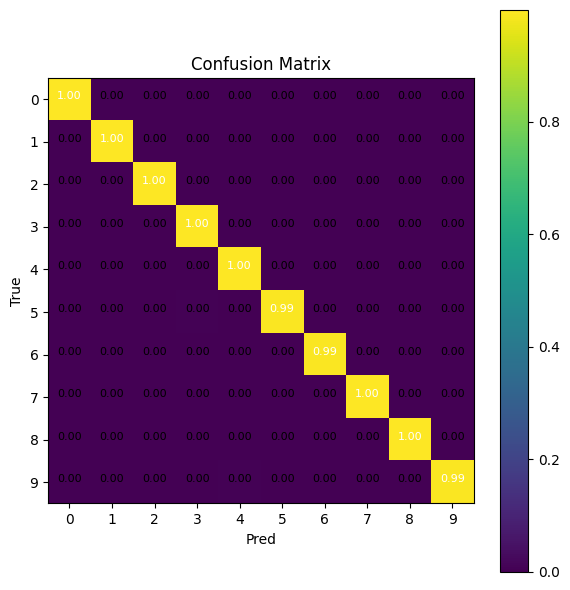

              precision    recall  f1-score   support

           0     0.9969    0.9990    0.9980       980
           1     0.9965    0.9982    0.9974      1135
           2     0.9981    0.9981    0.9981      1032
           3     0.9941    0.9970    0.9956      1010
           4     0.9949    0.9969    0.9959       982
           5     0.9955    0.9944    0.9950       892
           6     0.9979    0.9927    0.9953       958
           7     0.9951    0.9951    0.9951      1028
           8     0.9959    0.9959    0.9959       974
           9     0.9950    0.9921    0.9935      1009

    accuracy                         0.9960     10000
   macro avg     0.9960    0.9959    0.9960     10000
weighted avg     0.9960    0.9960    0.9960     10000



In [17]:
# GIẢ SỬ bạn đã có:
# - class SimpleCNN (từ câu B)
# - train_loader, val_loader, test_loader (từ câu A)
# - device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch, numpy as np, matplotlib.pyplot as plt, itertools
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

# 1) Khởi tạo model từ lớp đã định nghĩa ở câu B
model = SimpleCNNManual(num_classes=10).to(device)

# 2) Loss/Optimizer/Scheduler + EarlyStopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience, self.min_delta = patience, min_delta
        self.best = None; self.count = 0; self.stop = False
    def __call__(self, val_loss):
        if self.best is None or val_loss < self.best - self.min_delta:
            self.best = val_loss; self.count = 0
        else:
            self.count += 1
            if self.count >= self.patience: self.stop = True

def train_one_epoch(model, loader):
    model.train(); total=correct=0; run_loss=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits,y)
        loss.backward(); optimizer.step()
        run_loss += loss.item()*x.size(0)
        correct  += (logits.argmax(1)==y).sum().item()
        total    += x.size(0)
    return run_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); total=correct=0; run_loss=0.0
    preds_all, targets_all = [], []
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits,y)
        run_loss += loss.item()*x.size(0)
        correct  += (logits.argmax(1)==y).sum().item()
        total    += x.size(0)
        preds_all.append(logits.argmax(1).cpu())
        targets_all.append(y.cpu())
    preds_all   = torch.cat(preds_all).numpy()
    targets_all = torch.cat(targets_all).numpy()
    return run_loss/total, correct/total, preds_all, targets_all

def plot_confmat(y_true, y_pred, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    if normalize: cm = cm.astype(float)/cm.sum(axis=1, keepdims=True)
    import numpy as np
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix'); plt.colorbar()
    ticks = np.arange(10); labs=[str(i) for i in range(10)]
    plt.xticks(ticks,labs); plt.yticks(ticks,labs)
    fmt = '.2f' if normalize else 'd'; th = cm.max()/2
    for i in range(10):
        for j in range(10):
            plt.text(j,i,format(cm[i,j],fmt),ha='center',
                     color='white' if cm[i,j]>th else 'black', fontsize=8)
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

# 3) Train + validate
EPOCHS = 30
stopper = EarlyStopping(patience=5)
history = []
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc, _, _ = evaluate(model, val_loader)
    scheduler.step(va_loss); stopper(va_loss)
    history.append((ep, tr_loss, tr_acc, va_loss, va_acc, optimizer.param_groups[0]['lr']))
    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} "
          f"| val {va_loss:.4f}/{va_acc:.4f} | lr {optimizer.param_groups[0]['lr']:.2e}")
    if stopper.stop:
        print("Early stopping triggered."); break

# 4) Đánh giá cuối trên test (KHÔNG dùng để chọn tham số)
test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader)
print(f"\nTEST | loss {test_loss:.4f} | acc {test_acc:.4f}")

# 5) Confusion Matrix + báo cáo chi tiết
plot_confmat(y_true, y_pred)
print(classification_report(y_true, y_pred, digits=4))


### D – Tăng cường dữ liệu xoay (rotate), lật (flip), tịnh tiến

In [20]:
import torch
import torch.nn.functional as F
import math
# MNIST: H=W=28
MEAN, STD = 0.1307, 0.3081

def normalize_batch(x):
    # x ∈ [0,1]; chuẩn hoá tay theo thống kê MNIST
    return (x - MEAN) / STD

@torch.no_grad()
def manual_augment_batch(x, *,
                         p_rotate=1.0, max_deg=12,
                         p_translate=1.0, max_shift=0.10,   # tỉ lệ theo chiều ảnh (0.10 = 10%)
                         p_hflip=0.0):
    """
    x: (N,1,H,W) float32; trả về tensor cùng shape.
    - rotate: Uniform(-max_deg, max_deg) với xác suất p_rotate
    - translate: Uniform(-max_shift,+max_shift) * (W hoặc H) pixels với xác suất p_translate
    - hflip: lật ngang với xác suất p_hflip (CẢNH BÁO: có thể làm 6↔9, 2↔5)
    """

    N, C, H, W = x.shape
    x_aug = x

    # --- Lật ngang (không dùng affine để đơn giản)
    if p_hflip > 0:
        mask = (torch.rand(N, device=x.device) < p_hflip)
        if mask.any():
            x_aug[mask] = torch.flip(x_aug[mask], dims=[3])

    # --- Xoay + tịnh tiến (dùng affine_grid + grid_sample)
    do_affine = (p_rotate > 0 or p_translate > 0)
    if do_affine:
        # góc
        ang = torch.zeros(N, device=x.device)
        use_rot = (torch.rand(N, device=x.device) < p_rotate)
        if use_rot.any():
            ang[use_rot] = (torch.rand(use_rot.sum(), device=x.device)*2 - 1) * (max_deg * math.pi / 180.0)
        ca, sa = torch.cos(ang), torch.sin(ang)

        # tịnh tiến theo pixel
        tx_pix = torch.zeros(N, device=x.device)
        ty_pix = torch.zeros(N, device=x.device)
        use_tr  = (torch.rand(N, device=x.device) < p_translate)
        if use_tr.any():
            max_tx = max_shift * W
            max_ty = max_shift * H
            tx_pix[use_tr] = (torch.rand(use_tr.sum(), device=x.device)*2 - 1) * max_tx
            ty_pix[use_tr] = (torch.rand(use_tr.sum(), device=x.device)*2 - 1) * max_ty

        # Chuẩn hoá sang toạ độ [-1,1]
        tx = 2.0 * tx_pix / max(W-1, 1)
        ty = 2.0 * ty_pix / max(H-1, 1)

        # Ma trận affine (N,2,3): [[ca,-sa,tx],[sa,ca,ty]]
        theta = torch.zeros(N, 2, 3, device=x.device, dtype=x.dtype)
        theta[:,0,0] = ca; theta[:,0,1] = -sa; theta[:,0,2] = tx
        theta[:,1,0] = sa; theta[:,1,1] =  ca; theta[:,1,2] = ty

        grid = F.affine_grid(theta, x_aug.size(), align_corners=False)
        x_aug = F.grid_sample(x_aug, grid, mode='bilinear', padding_mode='zeros', align_corners=False)

    return x_aug


In [21]:
def train_one_epoch(model, loader, optimizer, criterion,
                    use_aug=False):
    model.train()
    total, correct, run_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x = normalize_batch(x)  # chuẩn hoá tay

        if use_aug:
            x = manual_augment_batch(
                x,
                p_rotate=1.0,   max_deg=12,   # xoay ±12°
                p_translate=1.0, max_shift=0.10, # tịnh tiến ≤10%
                p_hflip=0.00    # hoặc 0.05 nếu bắt buộc thử flip
            )

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward(); optimizer.step()

        run_loss += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += x.size(0)
    return run_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, run_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x = normalize_batch(x)  # KHÔNG augment
        logits = model(x)
        loss = criterion(logits, y)
        run_loss += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += x.size(0)
    return run_loss/total, correct/total


In [22]:
from copy import deepcopy
criterion = torch.nn.CrossEntropyLoss()

# (A) Không tăng cường
model_a = SimpleCNNManual().to(device)
opt_a = torch.optim.Adam(model_a.parameters(), lr=1e-3, weight_decay=1e-4)
for ep in range(10):
    tr_loss, tr_acc = train_one_epoch(model_a, train_loader, opt_a, criterion, use_aug=False)
    va_loss, va_acc = evaluate(model_a, val_loader, criterion)
    print(f"[NoAug] ep{ep+1:02d}  train {tr_acc:.4f}  val {va_acc:.4f}")
test_loss_a, test_acc_a = evaluate(model_a, test_loader, criterion)
print(f"[NoAug] Test acc: {test_acc_a:.4f}")

# (B) Có tăng cường tay
model_b = SimpleCNNManual().to(device)
opt_b = torch.optim.Adam(model_b.parameters(), lr=1e-3, weight_decay=1e-4)
for ep in range(10):
    tr_loss, tr_acc = train_one_epoch(model_b, train_loader, opt_b, criterion, use_aug=True)
    va_loss, va_acc = evaluate(model_b, val_loader, criterion)
    print(f"[Aug]   ep{ep+1:02d}  train {tr_acc:.4f}  val {va_acc:.4f}")
test_loss_b, test_acc_b = evaluate(model_b, test_loader, criterion)
print(f"[Aug]   Test acc: {test_acc_b:.4f}")

print(f"\nSo sánh: Test acc (NoAug) = {test_acc_a:.4f}   vs   (Aug) = {test_acc_b:.4f}")


[NoAug] ep01  train 0.7703  val 0.9733
[NoAug] ep02  train 0.9476  val 0.9848
[NoAug] ep03  train 0.9665  val 0.9860
[NoAug] ep04  train 0.9744  val 0.9892
[NoAug] ep05  train 0.9775  val 0.9895
[NoAug] ep06  train 0.9810  val 0.9905
[NoAug] ep07  train 0.9813  val 0.9915
[NoAug] ep08  train 0.9835  val 0.9912
[NoAug] ep09  train 0.9859  val 0.9933
[NoAug] ep10  train 0.9855  val 0.9920
[NoAug] Test acc: 0.9934
[Aug]   ep01  train 0.4630  val 0.9563
[Aug]   ep02  train 0.8914  val 0.9763
[Aug]   ep03  train 0.9393  val 0.9847
[Aug]   ep04  train 0.9536  val 0.9877
[Aug]   ep05  train 0.9618  val 0.9900
[Aug]   ep06  train 0.9670  val 0.9903
[Aug]   ep07  train 0.9705  val 0.9903
[Aug]   ep08  train 0.9720  val 0.9888
[Aug]   ep09  train 0.9736  val 0.9922
[Aug]   ep10  train 0.9761  val 0.9922
[Aug]   Test acc: 0.9939

So sánh: Test acc (NoAug) = 0.9934   vs   (Aug) = 0.9939


### F – Transfer learning & Fine-tuning

In [23]:
import torch, math
import torch.nn.functional as F
import torch.nn as nn

# Thống kê MNIST bạn dùng ở câu A
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

# Thống kê ImageNet
IM_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IM_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

@torch.no_grad()
def to_imagenet_input(x, use_aug=False,
                      p_rotate=1.0, max_deg=12,
                      p_translate=1.0, max_shift=0.10,
                      p_hflip=0.0):
    """
    x: (N,1,28,28) — giả định đang ở dạng đã normalize MNIST: (x-mean)/std.
    Trả về: (N,3,224,224) đã normalize theo ImageNet.
    """
    device = x.device
    # (1) hoàn tác chuẩn hoá MNIST -> về khoảng [0,1]
    x = x * MNIST_STD + MNIST_MEAN
    x = x.clamp(0, 1)

    # (2) Augment tay (xoay/dịch/lật) tái dùng hàm ở câu D nếu có.
    # Nếu bạn đã có manual_augment_batch, gọi thẳng:
    if use_aug:
        x = manual_augment_batch(
            x, p_rotate=p_rotate, max_deg=max_deg,
            p_translate=p_translate, max_shift=max_shift,
            p_hflip=p_hflip
        )

    # (3) 1 kênh -> 3 kênh
    x = x.repeat(1, 3, 1, 1)

    # (4) Resize 28 -> 224
    x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

    # (5) Chuẩn hoá ImageNet
    x = (x - IM_MEAN.to(device)) / IM_STD.to(device)
    return x


In [24]:
def train_one_epoch_tl(model, loader, optimizer, criterion, use_aug):
    model.train()
    tot=correct=0; run_loss=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        x = to_imagenet_input(x, use_aug=use_aug)  # << quan trọng
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward(); optimizer.step()
        run_loss += loss.item()*x.size(0)
        correct  += (logits.argmax(1)==y).sum().item()
        tot      += x.size(0)
    return run_loss/tot, correct/tot

@torch.no_grad()
def evaluate_tl(model, loader, criterion):
    model.eval()
    tot=correct=0; run_loss=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        x = to_imagenet_input(x, use_aug=False)
        logits = model(x)
        loss = criterion(logits, y)
        run_loss += loss.item()*x.size(0)
        correct  += (logits.argmax(1)==y).sum().item()
        tot      += x.size(0)
    return run_loss/tot, correct/tot


In [30]:
# 0) sau khi RESTART kernel
import os; os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch, torch.nn as nn
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) model
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

try:
    resnet = resnet.to(device, non_blocking=True)
except RuntimeError as e:
    print("GPU move failed; fallback CPU:", e)
    device = torch.device("cpu"); resnet = resnet.to(device)

# 2) dùng loader TL batch nhỏ, và các hàm SAFE:
# train_loader_tl / val_loader_tl / test_loader_tl (batch 16–32)
# to_imagenet_input_safe(...) trong train_one_epoch_tl / evaluate_tl

criterion = nn.CrossEntropyLoss()
for n,p in resnet.named_parameters():
    p.requires_grad = n.startswith("fc.")
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-3)

# train vài epoch với use_aug=False trước để loại trừ lỗi augment


GPU move failed; fallback CPU: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [ ]:
# import torch, platform
# print("PyTorch:", torch.__version__)
# print("CUDA (built):", torch.version.cuda)
# print("Device:", torch.cuda.get_device_name(0))
# print("Compute capability:", torch.cuda.get_device_capability())
# print("cuDNN:", torch.backends.cudnn.version())


PyTorch: 2.5.1+cu121
CUDA (built): 12.1
Device: NVIDIA GeForce RTX 4070 Laptop GPU
Compute capability: (8, 9)
cuDNN: 90100


In [ ]:
# import torch
# x = torch.zeros(1, device="cuda")
# print(x)
# print(torch.sum(x).item())

In [36]:
vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
# thay head 10 lớp
vgg.classifier[-1] = nn.Linear(vgg.classifier[-1].in_features, 10)
device = torch.device("cpu")


print("Using device:", device)
vgg = vgg.to(device)

# TRANSFER: đóng băng tất cả trừ lớp cuối cùng của classifier
for name, p in vgg.named_parameters():
    p.requires_grad = name.startswith("classifier.6")

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=1e-3)

print("== Transfer (train last FC) ==")
for ep in range(1, 6+1):
    tr_loss, tr_acc = train_one_epoch_tl(vgg, train_loader, opt, criterion, use_aug=True)
    va_loss, va_acc = evaluate_tl(vgg, val_loader, criterion)
    print(f"Ep {ep:02d} | train {tr_acc:.4f}  val {va_acc:.4f}")

# FINE-TUNE: mở khoá classifier toàn bộ + block conv cuối (conv5)
for name, p in vgg.named_parameters():
    if name.startswith("features."):
        # với vgg16_bn, các lớp conv5 ~ index >= 40
        idx = int(name.split('.')[1]) if '.' in name else -1
        p.requires_grad = idx >= 40
    elif name.startswith("classifier."):
        p.requires_grad = True
    else:
        p.requires_grad = False

opt = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=3e-4)

print("== Fine-tune (conv5 + classifier) ==")
for ep in range(1, 6+1):
    tr_loss, tr_acc = train_one_epoch_tl(vgg, train_loader, opt, criterion, use_aug=True)
    va_loss, va_acc = evaluate_tl(vgg, val_loader, criterion)
    print(f"Ep {ep:02d} | train {tr_acc:.4f}  val {va_acc:.4f}")

test_loss_v, test_acc_v = evaluate_tl(vgg, test_loader, criterion)
print(f"[VGG16 TL+FT] Test acc = {test_acc_v:.4f}")


Using device: cpu
== Transfer (train last FC) ==


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
